# Computational Genomics Project

You can use this notebook as a code template for your MDE analysis :)
for preprocessing used: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

# Load data

I have created an h5 file with will serve as our base dataset. It contains the normalized and gene-filtered expression matrix of single-cell RNA-seq data of ~3k PBMC cells fobtained from a healthy donor.

In [3]:
# Loading the data into a ScanPy AnnData object with read()
base_file = 'pbmc3k_base.h5ad'
data = sc.read(base_file)

You can get a high-level description of the data contained in the h5 file with print(). The *AnnData* stands for stands for annotated data matrix. This object has several attributes that we will use to access the data.

In [4]:
print(data)

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    obsp: 'connectivities', 'distances'


The *obs* attribute is a Pandas dataframe that contains meta information about the data, such as the cell barcodes and cell type labels. 

In [5]:
data.obs.head(5)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD8 T
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,CD14 Monocytes
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK


## Train-Test Split

Now we will split our data into a training and test set. To do this, we will need the individual cell barcodes, which are the row names of the *obs* dataframe. Once we have the split assignments, we add them as a new column to the dtaframe.

In [6]:
X = data.obs.index.to_list()
X_train, X_test = train_test_split(list(enumerate(X)), test_size=0.3, random_state=42)

In [7]:
splits=[]
train_samples = [i[1] for i in X_train]
for cell_id in X:
    if cell_id in train_samples:
        splits.append('train')
    else:
        splits.append('test')
data.obs['split'] = splits
data.obs.head(5)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type,split
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD8 T,train
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B,train
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T,train
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,CD14 Monocytes,train
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK,train


## Dimensionality Reduction Baselines

Lastly, we will perform dimensionality reduction on our training and test expression matrices using PCA, tSNE, and UMAP. The expression matrix of the entire dataset can be accessed via the *X* attribute. The resulting embeddings for the training and test sets are what we will be using to perform our benchmark comparisons.

In [8]:
train_samples_indices = [i[0] for i in X_train]
train_samples_indices.sort()
test_samples_indices = [i[0] for i in X_test]
test_samples_indices.sort()


data.X[train_samples_indices,:].shape

(1846, 1838)

In [9]:
from sklearn.decomposition import PCA

dr_pca = PCA(n_components=2, random_state=42)
dr_pca.fit(data.X[train_samples_indices,:])

pca_train = dr_pca.transform(data.X[train_samples_indices,:])
pca_test = dr_pca.transform(data.X[test_samples_indices,:])

In [10]:
from sklearn.manifold import TSNE

dr_tsne = TSNE(n_components=2, random_state=42)

##tsne_train = dr_tsne.fit_transform(data.X[train_samples_indices,:])
tsne_train = dr_tsne.fit_transform(pca_train)
##tsne_test = dr_tsne.fit_transform(data.X[test_samples_indices,:])
tsne_test = dr_tsne.fit_transform(pca_test)

In [11]:
from umap import UMAP

dr_umap = UMAP(n_components=2, random_state=42)
##dr_umap.fit(data.X[train_samples_indices,:])
dr_umap.fit(pca_train)

##umap_train = dr_umap.transform(data.X[train_samples_indices,:])
umap_train = dr_umap.transform(pca_train)
##umap_test = dr_umap.transform(data.X[test_samples_indices,:])
umap_test = dr_umap.transform(pca_test)

## MDE Analysis - Deviation Based

In [12]:
import pymde

In [13]:
import torch

mde = pymde.preserve_neighbors(
    np.vstack([pca_train, pca_test]),
    embedding_dim=2,
    constraint=pymde.Standardized(),
    repulsive_fraction=1,
    n_neighbors=10,
    max_distance=100,
    verbose=True,
    device='cpu'
)
embedding = mde.embed(verbose=True)

May 04 09:59:48 AM: Computing 10-nearest neighbors, with max_distance=100
May 04 09:59:48 AM: Exact nearest neighbors by brute force 
May 04 09:59:48 AM: Computing quadratic initialization.
May 04 09:59:48 AM: Fitting a standardized embedding into R^2, for a graph with 2638 items and 31636 edges.
May 04 09:59:48 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
May 04 09:59:48 AM: iteration 000 | distortion 0.291775 | residual norm 0.0636565 | step length 0.558507 | percent change 0.0489462
May 04 09:59:48 AM: iteration 030 | distortion 0.168950 | residual norm 0.000983572 | step length 1 | percent change 1.66721
May 04 09:59:49 AM: iteration 060 | distortion 0.165306 | residual norm 0.000488654 | step length 1 | percent change 0.520668
May 04 09:59:49 AM: iteration 090 | distortion 0.164856 | residual norm 0.000208457 | step length 1 | percent change 0.151448
May 04 09:59:49 AM: iteration 120 | distortion 0.164772 | residual norm 0.000267736 | step length 1 | pe

In [17]:
mde_train = embedding[:pca_train.shape[0], :]
mde_test = embedding[pca_train.shape[0]:, :]

#np.save('./mde_train.npy', mde_train)
#np.save('./mde_test.npy', mde_test)

## Visualize Embeddings with Minimum distortion embedding(MDE), PCA, TSNE, UMAP 

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


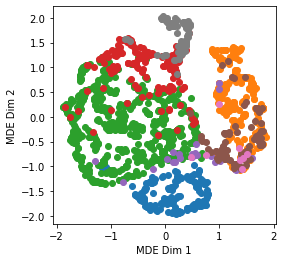

In [20]:
## PCA on dataset 


df = data.obs[data.obs['split'] == 'train']
df['x'] = mde_train[:,0]
df['y'] = mde_train[:,1]

plt.figure(figsize=(4, 4))
for ct in np.unique(df.cell_type):
    plt.scatter(df[df.cell_type == ct].x , df[df.cell_type == ct].y , label = ct)

plt.xlabel('MDE Dim 1')
plt.ylabel('MDE Dim 2')
#plt.legend()
plt.show()

<AxesSubplot:>

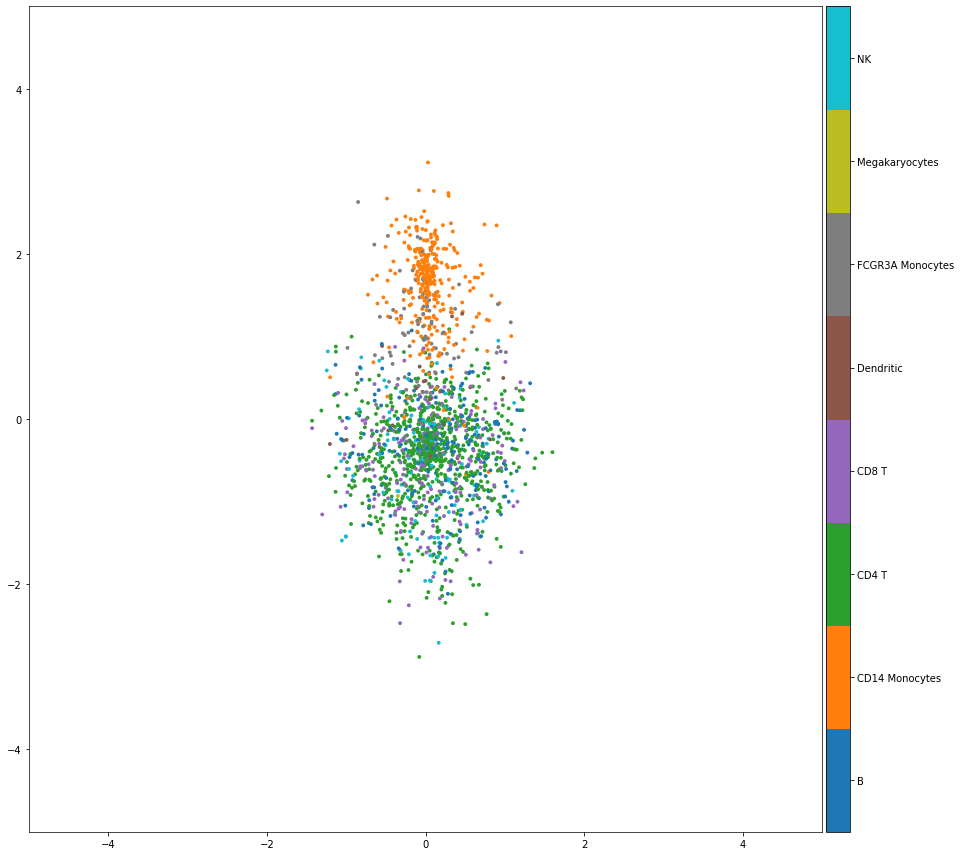

In [16]:
pymde.plot(
    mde_train,
    color_by=data.obs[data.obs['split'] == 'train']['cell_type'],
    color_map='tab10',
    figsize_inches=(12, 12),
    marker_size=15,
    axis_limits=(-5,5)
)

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


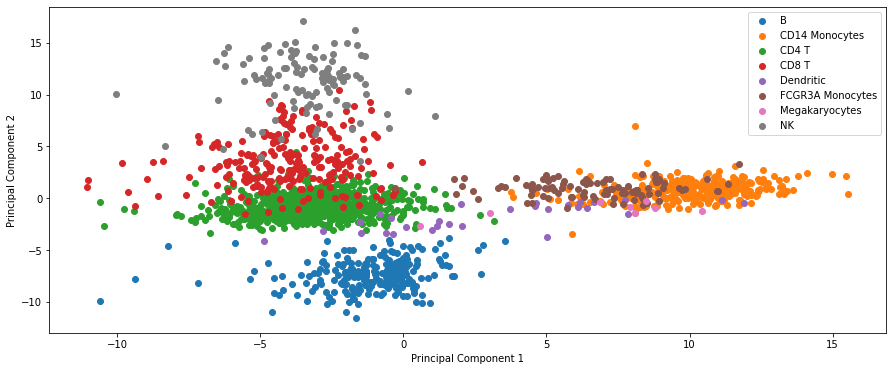

In [19]:
## PCA on dataset 


df = data.obs[data.obs['split'] == 'train']
df['x'] = pca_train[:,0]
df['y'] = pca_train[:,1]

plt.figure(figsize=(15, 6))
for ct in np.unique(df.cell_type):
    plt.scatter(df[df.cell_type == ct].x , df[df.cell_type == ct].y , label = ct)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2') 
plt.legend()
plt.show()

In [18]:
#df = df.drop([df.index[df.y.argmin()], df.index[df.y.argmax()]], axis=0)

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


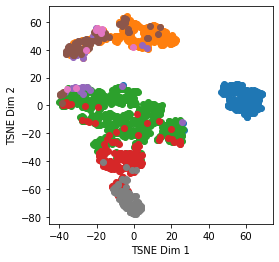

In [22]:
## TSNE on dataset 


df = data.obs[data.obs['split'] == 'train']
df['x'] = tsne_train[:,0]
df['y'] = tsne_train[:,1]

plt.figure(figsize=(4, 4))
for ct in np.unique(df.cell_type):
    plt.scatter(df[df.cell_type == ct].x , df[df.cell_type == ct].y , label = ct)
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
#plt.legend()
plt.show()

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


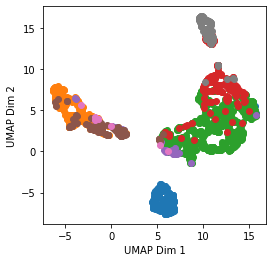

In [23]:
## UMAP on dataset 

df = data.obs[data.obs['split'] == 'train']
df['x'] = umap_train[:,0]
df['y'] = umap_train[:,1]

plt.figure(figsize=(4, 4))
for ct in np.unique(df.cell_type):
    plt.scatter(df[df.cell_type == ct].x , df[df.cell_type == ct].y , label = ct)
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
#plt.legend()
plt.show()

In [21]:
data.obs.cell_type

AAACATACAACCAC-1             CD8 T
AAACATTGAGCTAC-1                 B
AAACATTGATCAGC-1             CD4 T
AAACCGTGCTTCCG-1    CD14 Monocytes
AAACCGTGTATGCG-1                NK
                         ...      
TTTCGAACTCTCAT-1    CD14 Monocytes
TTTCTACTGAGGCA-1                 B
TTTCTACTTCCTCG-1                 B
TTTGCATGAGAGGC-1                 B
TTTGCATGCCTCAC-1             CD4 T
Name: cell_type, Length: 2638, dtype: category
Categories (8, object): ['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes', 'Dendritic', 'Megakaryocytes']

# KNN Classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neigh_pca = KNeighborsClassifier()
df_train = data.obs[data.obs['split'] == 'train']
df_test = data.obs[data.obs['split'] == 'test']
neigh_pca.fit(pca_train,df_train['cell_type'])
y_knn_pca = neigh_pca.predict (pca_test)
# print (y_predict)
# print (df_pca_test)
print ("PCA accuracy = ", accuracy_score (df_test['cell_type'], y_knn_pca))

PCA accuracy =  0.8813131313131313


In [23]:
neigh_tsne = KNeighborsClassifier()
neigh_tsne.fit(tsne_train,df_train['cell_type'])
y_knn_tsne = neigh_tsne.predict (tsne_test)
print ("tSNE accuracy = ", accuracy_score (df_test['cell_type'], y_knn_tsne))

tSNE accuracy =  0.13636363636363635


In [24]:
neigh_umap = KNeighborsClassifier()
neigh_umap.fit(umap_train,df_train['cell_type'])
y_knn_umap = neigh_umap.predict (umap_test)
print ("UMAP accuracy = ", accuracy_score (df_test['cell_type'], y_knn_umap))

UMAP accuracy =  0.42803030303030304


In [25]:
neigh_mde = KNeighborsClassifier()
neigh_mde.fit(mde_train,df_train['cell_type'])
print (mde_train.shape)
print (mde_test.shape)
y_knn_mde = neigh_mde.predict (mde_test)
print ("MDE accuracy = ", accuracy_score (df_test['cell_type'], y_knn_mde))

torch.Size([1846, 2])
torch.Size([792, 2])
MDE accuracy =  0.5252525252525253


In [26]:
# #from matplotlib import pyplot as plt
# from sklearn.mixture import GaussianMixture
# n_components=8
# gmm=GaussianMixture(n_components, covariance_type='full', max_iter=100)

# from sklearn.metrics import accuracy_score

# df_train = data.obs[data.obs['split'] == 'train']
# df_test = data.obs[data.obs['split'] == 'test']
# gmm.fit(pca_train,df_train['cell_type'])
# y_predict_pca = gmm.predict (pca_test)
# print(pca_train)
# print(df_train['cell_type'])
# print(pca_test)
# print(df_test['cell_type'])
# print(y_predict_pca)

# #isinstance(y_predict_pca, np.ndarray)

# # # y_predict_pca_list=(y_predict_pca).tolist()
# # print(y_predict_pca_list)
# replacements = {
#     1:'CD4 T',
#     2:'CD14 Monocytes',
#     3:'B',
#     4:'CD8 T',
#     5:'NK',
#     6:'FCGR3A Monocytes',
#     7:'Dendritic',
#     8:'Megakaryocytes'
# }

# p = [replacements.get(x, x) for x in y_predict_pca]
# print(p)

# arraypca=np.array(p)
# print(arraypca)
# # printed p and arraypca becuase wasnt sure about what type of structure is p but its also array but seperated with commas 
# # accuracy is same in both cases as you can see in below output
# print ("PCA accuracy = ", accuracy_score ( p,df_test['cell_type']))
# print ("PCA accuracy = ", accuracy_score (df_test['cell_type'], arraypca))


# GMM accuracy results for pca, tsne ,umap and MDE are poorer than k neighbours.

# Also highly variable final accuracy outputs so set seed as 40 as its stochastic .Set n_component as 8 as there are 8 clusters  

In [27]:



#from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
n_components=8
#random_state=42
# gmm=GaussianMixture(n_components, covariance_type='full', max_iter=100)
gmm=GaussianMixture(n_components, random_state=40)
from sklearn.metrics import accuracy_score

df_train = data.obs[data.obs['split'] == 'train']
df_test = data.obs[data.obs['split'] == 'test']
gmm.fit(pca_train,df_train['cell_type'])
y_predict_pca = gmm.predict (pca_test)
# print(pca_train)
# print(df_train['cell_type'])
# print(pca_test)
# print(df_test['cell_type'])
#print(y_predict_pca)

#isinstance(y_predict_pca, np.ndarray)

# # y_predict_pca_list=(y_predict_pca).tolist()
# print(y_predict_pca_list)
replacements = {
    0:'CD4 T',
    1:'CD14 Monocytes',
    2:'B',
    3:'CD8 T',
    4:'NK',
    5:'FCGR3A Monocytes',
    6:'Dendritic',
    7:'Megakaryocytes'
}

p = [replacements.get(x, x) for x in y_predict_pca]
arraypca=np.array(p)

print ("PCA accuracy = ", accuracy_score (df_test['cell_type'], arraypca))



PCA accuracy =  0.577020202020202


In [28]:
# #from matplotlib import pyplot as plt
# from sklearn.mixture import GaussianMixture
# n_components=8
# gmm=GaussianMixture(n_components, covariance_type='full', max_iter=100)

# from sklearn.metrics import accuracy_score

# df_train = data.obs[data.obs['split'] == 'train']
# df_test = data.obs[data.obs['split'] == 'test']
# gmm.fit(pca_train,df_train['cell_type'])
# y_predict_pca = gmm.predict (pca_test)
# print(pca_train)
# print(df_train['cell_type'])
# print(pca_test)
# print(df_test['cell_type'])
# print(y_predict_pca)




# print ("PCA accuracy = ", accuracy_score ( y_predict_pca,df_test['cell_type']))

In [29]:
gmm.fit(tsne_train,df_train['cell_type'])
y_predict_tsne = gmm.predict (tsne_test)
print(tsne_train)
print(tsne_test)
print(y_predict_tsne)

replacements = {
    0:'CD4 T',
    1:'CD14 Monocytes',
    2:'B',
    3:'CD8 T',
    4:'NK',
    5:'FCGR3A Monocytes',
    6:'Dendritic',
    7:'Megakaryocytes'
}

t = [replacements.get(x, x) for x in y_predict_tsne]
arraytsne=np.array(t)
print ("tSNE accuracy = ", accuracy_score (df_test['cell_type'], arraytsne))

[[-1.1740391  -2.3922746 ]
 [-1.9972825  -1.5485331 ]
 [-0.18277842 -1.0300453 ]
 ...
 [-1.9792507  -2.4682102 ]
 [-2.4827428  -1.3581138 ]
 [-2.6412745  -0.20022984]]
[[  83.65832      84.552765  ]
 [  50.757603    -37.535027  ]
 [ -32.519077     43.837215  ]
 ...
 [-110.6445       29.827631  ]
 [ -91.057724     31.962614  ]
 [ -38.348183     -0.35280624]]
[3 0 0 3 0 7 3 3 3 0 0 0 0 7 3 0 7 3 0 7 7 0 7 7 0 0 0 7 0 7 0 7 0 7 0 0 3
 7 0 7 3 0 7 7 0 0 7 7 3 0 7 0 3 7 7 3 7 7 0 7 0 3 7 7 0 0 7 7 3 0 3 3 7 7
 3 3 0 7 0 0 7 0 0 7 0 0 7 7 0 0 0 7 0 0 7 0 0 3 3 0 0 0 3 7 0 0 3 7 7 0 3
 7 7 0 7 7 3 7 3 0 0 3 3 0 7 3 7 0 0 3 7 7 0 0 7 0 0 7 7 0 3 7 7 7 0 0 7 3
 3 3 0 7 7 7 0 0 0 0 7 7 7 0 7 0 0 7 0 7 7 7 0 7 0 3 7 0 0 7 7 3 3 0 0 0 7
 0 7 0 0 0 0 7 0 7 0 0 7 0 0 7 3 0 7 3 0 7 7 7 0 3 7 0 0 0 0 0 3 3 3 0 7 7
 0 3 7 7 7 7 3 0 7 0 0 0 0 0 0 0 7 3 3 7 0 3 0 3 0 3 3 0 3 7 3 7 7 7 3 7 7
 7 0 7 3 0 7 0 3 0 0 0 7 3 0 7 7 0 7 7 3 7 3 7 0 7 7 7 7 0 7 0 0 3 3 3 0 7
 7 7 3 0 3 7 3 0 0 0 0 0 3 3 7 3 0 7 3 3

In [30]:
gmm.fit(umap_train,df_train['cell_type'])
y_predict_umap = gmm.predict (umap_test)
replacements = {
    0:'CD4 T',
    1:'CD14 Monocytes',
    2:'B',
    3:'CD8 T',
    4:'NK',
    5:'FCGR3A Monocytes',
    6:'Dendritic',
    7:'Megakaryocytes'
}

u = [replacements.get(x, x) for x in y_predict_umap]


arrayumap=np.array(u)


print ("UMAP accuracy = ", accuracy_score (df_test['cell_type'],arrayumap ))

UMAP accuracy =  0.12373737373737374


In [31]:
gmm.fit(mde_train,df_train['cell_type'])
print (mde_train.shape)
print (mde_test.shape)
y_predict_mde = gmm.predict (mde_test)



replacements = {
    0:'CD4 T',
    1:'CD14 Monocytes',
    2:'B',
    3:'CD8 T',
    4:'NK',
    5:'FCGR3A Monocytes',
    6:'Dendritic',
    7:'Megakaryocytes'
}

m = [replacements.get(x, x) for x in y_predict_mde]


arraymde=np.array(m)


print ("MDE accuracy = ", accuracy_score (df_test['cell_type'], arraymde))

torch.Size([1846, 2])
torch.Size([792, 2])
MDE accuracy =  0.10101010101010101


In [32]:
# # looking at the numpy data
# import numpy as np
# mde_train = np.load("mde_train.npy")
# mde_test = np.load("mde_test.npy")
# print(mde_train.shape)
# print(mde_train)
# print(mde_test.shape)
# print(mde_test)

In [33]:
# from matplotlib import pyplot as plt
# from sklearn import mixture
# n_components=2
# gmm=mixture.GaussianMixture(n_components, covariance_type='full', max_iter=100)
# gmm.fit(mde_train)
# print(gmm.means_.shape)
# print(gmm.means_)
# print(gmm.covariances_)
# print(gmm.covariances_.shape)
# # gmm_predicted_states=gmm_model.predict(mde_test)
# gmm_predicted_states=gmm.predict(mde_test)
# print("printing gmm predicted values")
# print(gmm_predicted_states)

In [34]:
# import pandas as pd
# df_train=pd.DataFrame(mde_train)
# plt.scatter(df_train.iloc[:, 0], df_train.iloc[:,1])
# plt.show()

In [35]:
# df_test=pd.DataFrame(mde_test)
# plt.scatter(df_test.iloc[:, 0], df_test.iloc[:,1])
# plt.show()

In [36]:
# df_test['labels']=gmm_predicted_states
# df_0=df_test[df_test['labels']==0]
# df_1=df_test[df_test['labels']==1]
# plt.figure()
# plt.scatter(df_0[0], df_0[1], c='g')
# plt.scatter(df_1[0], df_1[1], c='r')

# plt.show()
   

In [37]:
# #from matplotlib import pyplot as plt
# from sklearn import mixture
# n_components=8
# gmm=mixture.GaussianMixture(n_components, covariance_type='full', max_iter=100)
# from sklearn.metrics import accuracy_score

# df_train = data.obs[data.obs['split'] == 'train']
# df_test = data.obs[data.obs['split'] == 'test']
# gmm.fit(pca_train,df_train['cell_type'])
# y_predict_pca = gmm.predict (pca_test)

# print ("PCA accuracy = ", accuracy_score (df_test['cell_type'], y_predict_pca))



In [38]:
import seaborn as sb
from sklearn import metrics
from sklearn.metrics import confusion_matrix


def Heatmap(y_true, y_preds, labels):
    """ Plot the heatmap for prediction
    y_true - the true label for each test cell for 10 iterations, should be with length 1800
    y_pred - the predict label for each test cell for 10 iterations, should be with length 1800
    labels - the order of the labels (unique_labels)
    path - file path to save plot (must end with '.eps')
    """
    confusion_array = [confusion_matrix(y_true, y_pred, labels)/10 for y_pred in y_preds]
    sb.set(font_scale=1)
    
    
    fig, (ax1, ax2, axcb) = plt.subplots(1, 3, figsize=(12, 6), dpi= 200, gridspec_kw={'width_ratios':[1,1,0.05]})
    ax1.get_shared_y_axes().join(ax2)
    g1 = sb.heatmap(
        confusion_array[0],
        cmap="Blues",
        cbar=False,
        ax=ax1,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"shrink": 0.5}
    )
    g1.set_ylabel('')
    g1.set_xlabel('')
    g2 = sb.heatmap(
        confusion_array[1],
        cmap="Blues",
        ax=ax2,
        cbar_ax=axcb,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"shrink": 0.5}
    )
    g2.set_ylabel('')
    g2.set_xlabel('')
    g2.set_yticks([])

    
    # may be needed to rotate the ticklabels correctly:
    for ax in [g1,g2]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl)
        tly = ax.get_yticklabels()
        ax.set_yticklabels(tly)
    

    
    plt.subplots_adjust(hspace = 0.8)
    plt.subplots_adjust(left=0.3)
    #plt.xlabel('Predicted Label')
    #plt.ylabel('Actual Label')
    plt.xticks([])
    plt.show()


def plot_ROC_curve(y_true, y_score, ax, color):
    total_pos = np.sum(y_true == 1)
    total_neg = np.sum(y_true == 0)

    thresholds = np.linspace(0, 1, 100)
    tpr = np.zeros(100)
    fpr = np.zeros(100)
    F1_scores = np.zeros(100)
    for idx in range(100):
        y_hat = (y_score > thresholds[idx]).astype(np.int)
        tp = np.logical_and(y_hat == 1, y_true == 1).sum()
        fp = np.logical_and(y_hat == 1, y_true == 0).sum()

        tp_rate = tp/total_pos
        fp_rate = fp/total_neg

        if (tp + fp) == 0:
            ppv = 0
        else:
            ppv = tp / (tp + fp)

        if ppv == 0:
            score = 0
        else:
            score = 2 * (ppv * tp_rate)/(ppv + tp_rate)

        tpr[idx] = tp_rate
        fpr[idx] = fp_rate
        F1_scores[idx] = score

    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle='solid', color=color, linewidth=3)
    return auc, F1_scores

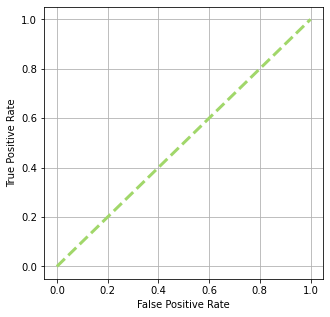

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
diag_x, diag_y = [0, 1], [0, 1]
ax.plot(diag_x, diag_y, linestyle='dashed', color='#a1d76a', linewidth=3)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

In [40]:
m = [replacements.get(x, x) for x in y_predict_mde]

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['CD8 T' 'B' 'CD4 T' 'CD14 Monocytes' 'NK' 'FCGR3A Monocytes' 'Dendritic'
 'Megakaryocytes'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


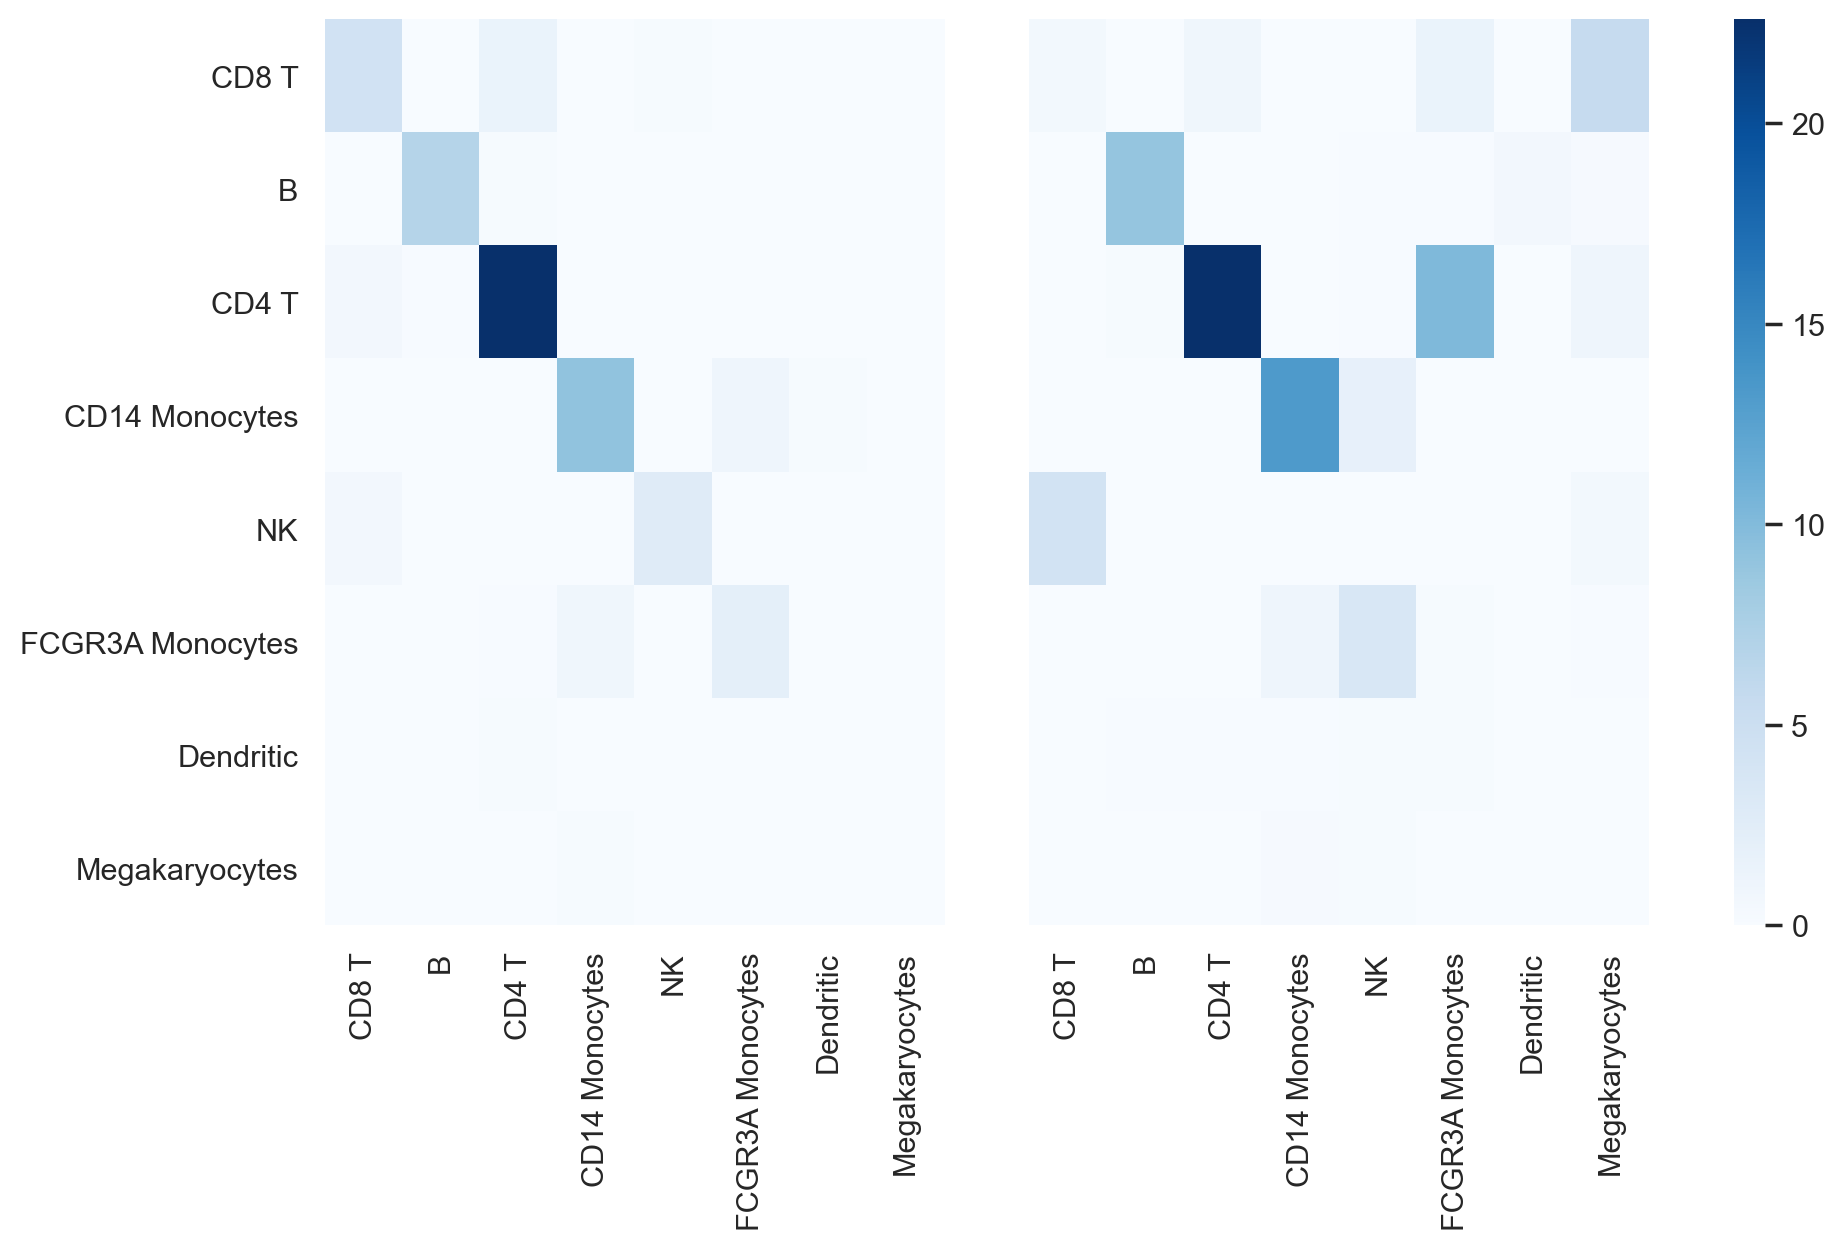

In [41]:
unique_classes = np.array(df.cell_type.unique(), dtype='<U20')

#Heatmap(df_test['cell_type'], arraypca, unique_classes)
Heatmap(df_test['cell_type'], [y_knn_pca, arraypca], unique_classes)

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


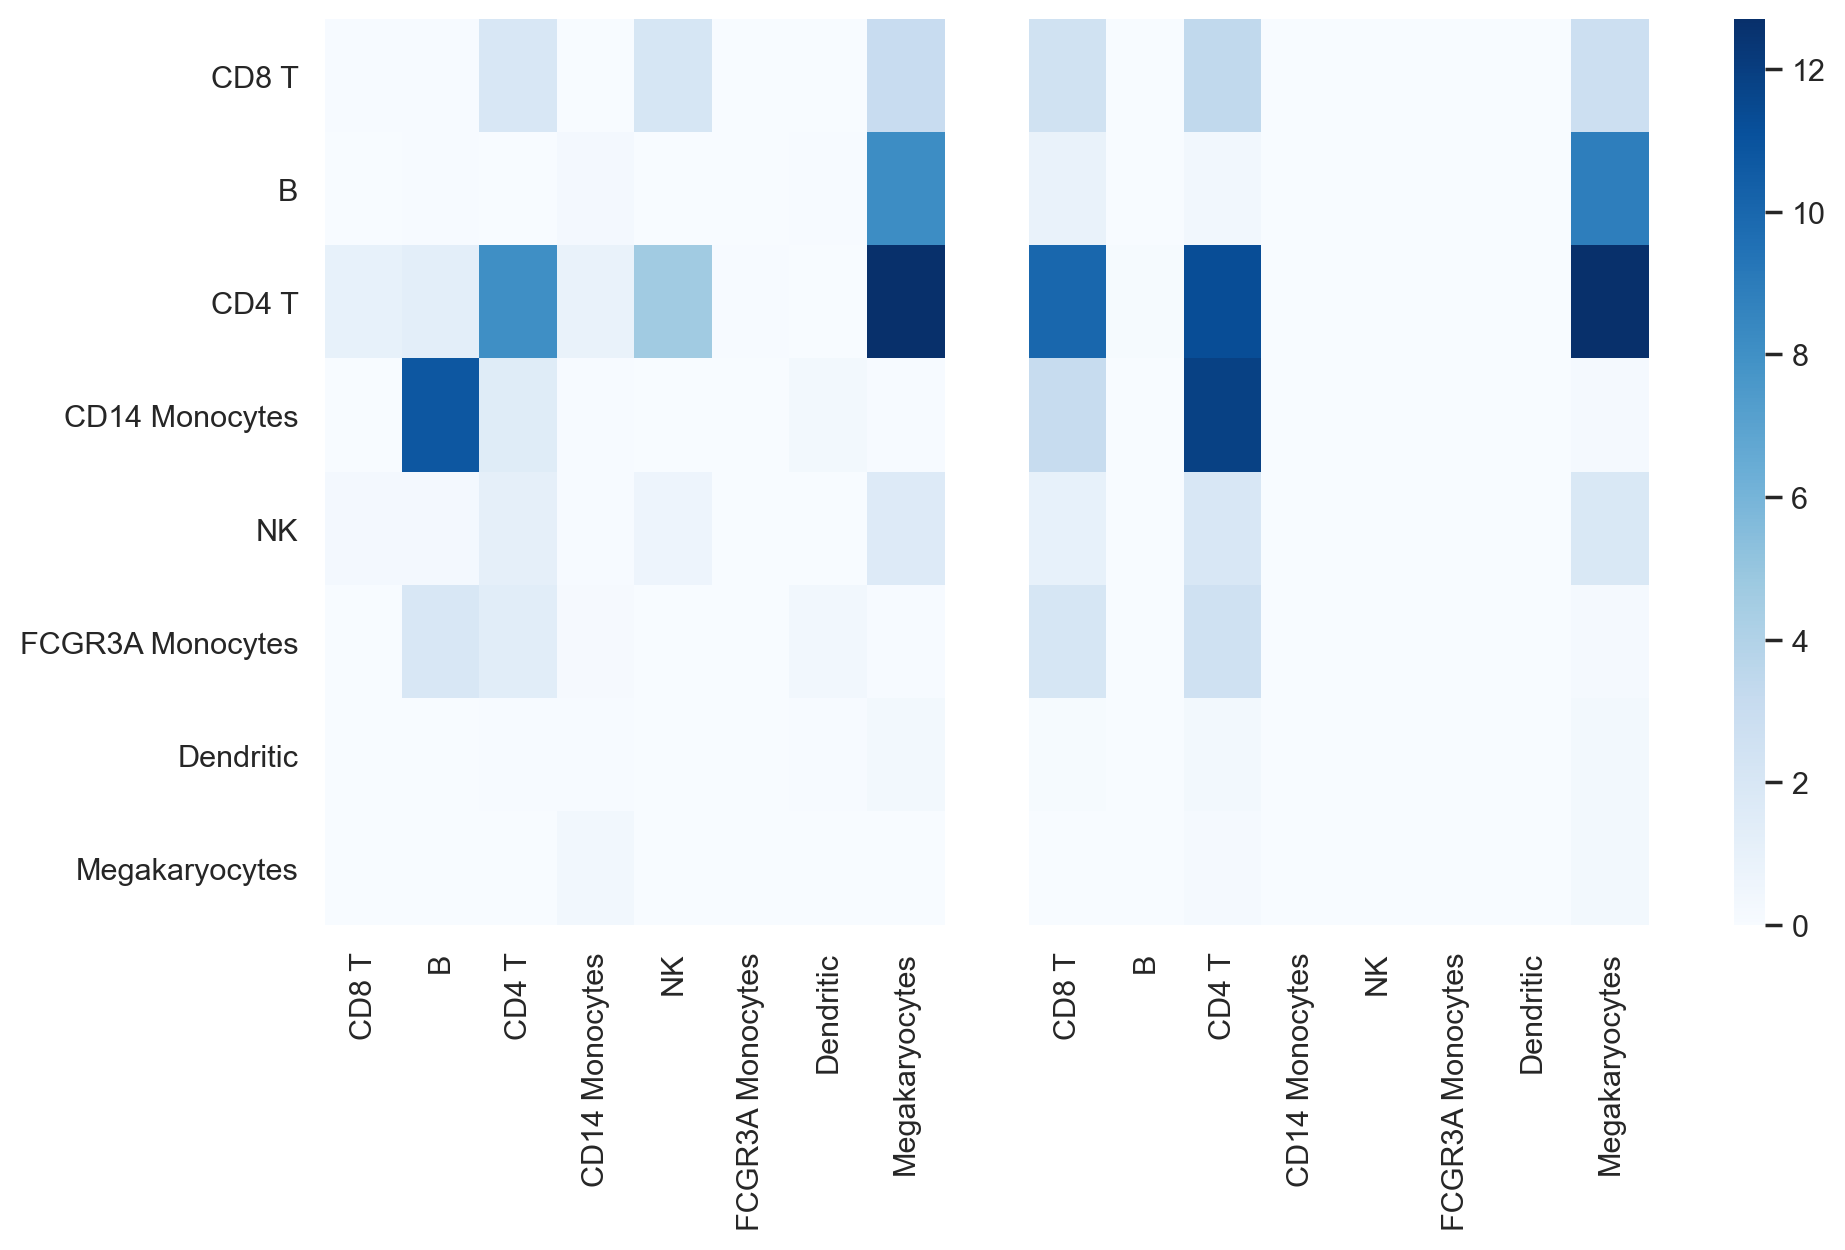

In [42]:
Heatmap(df_test['cell_type'], [y_knn_tsne, arraytsne], unique_classes)

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


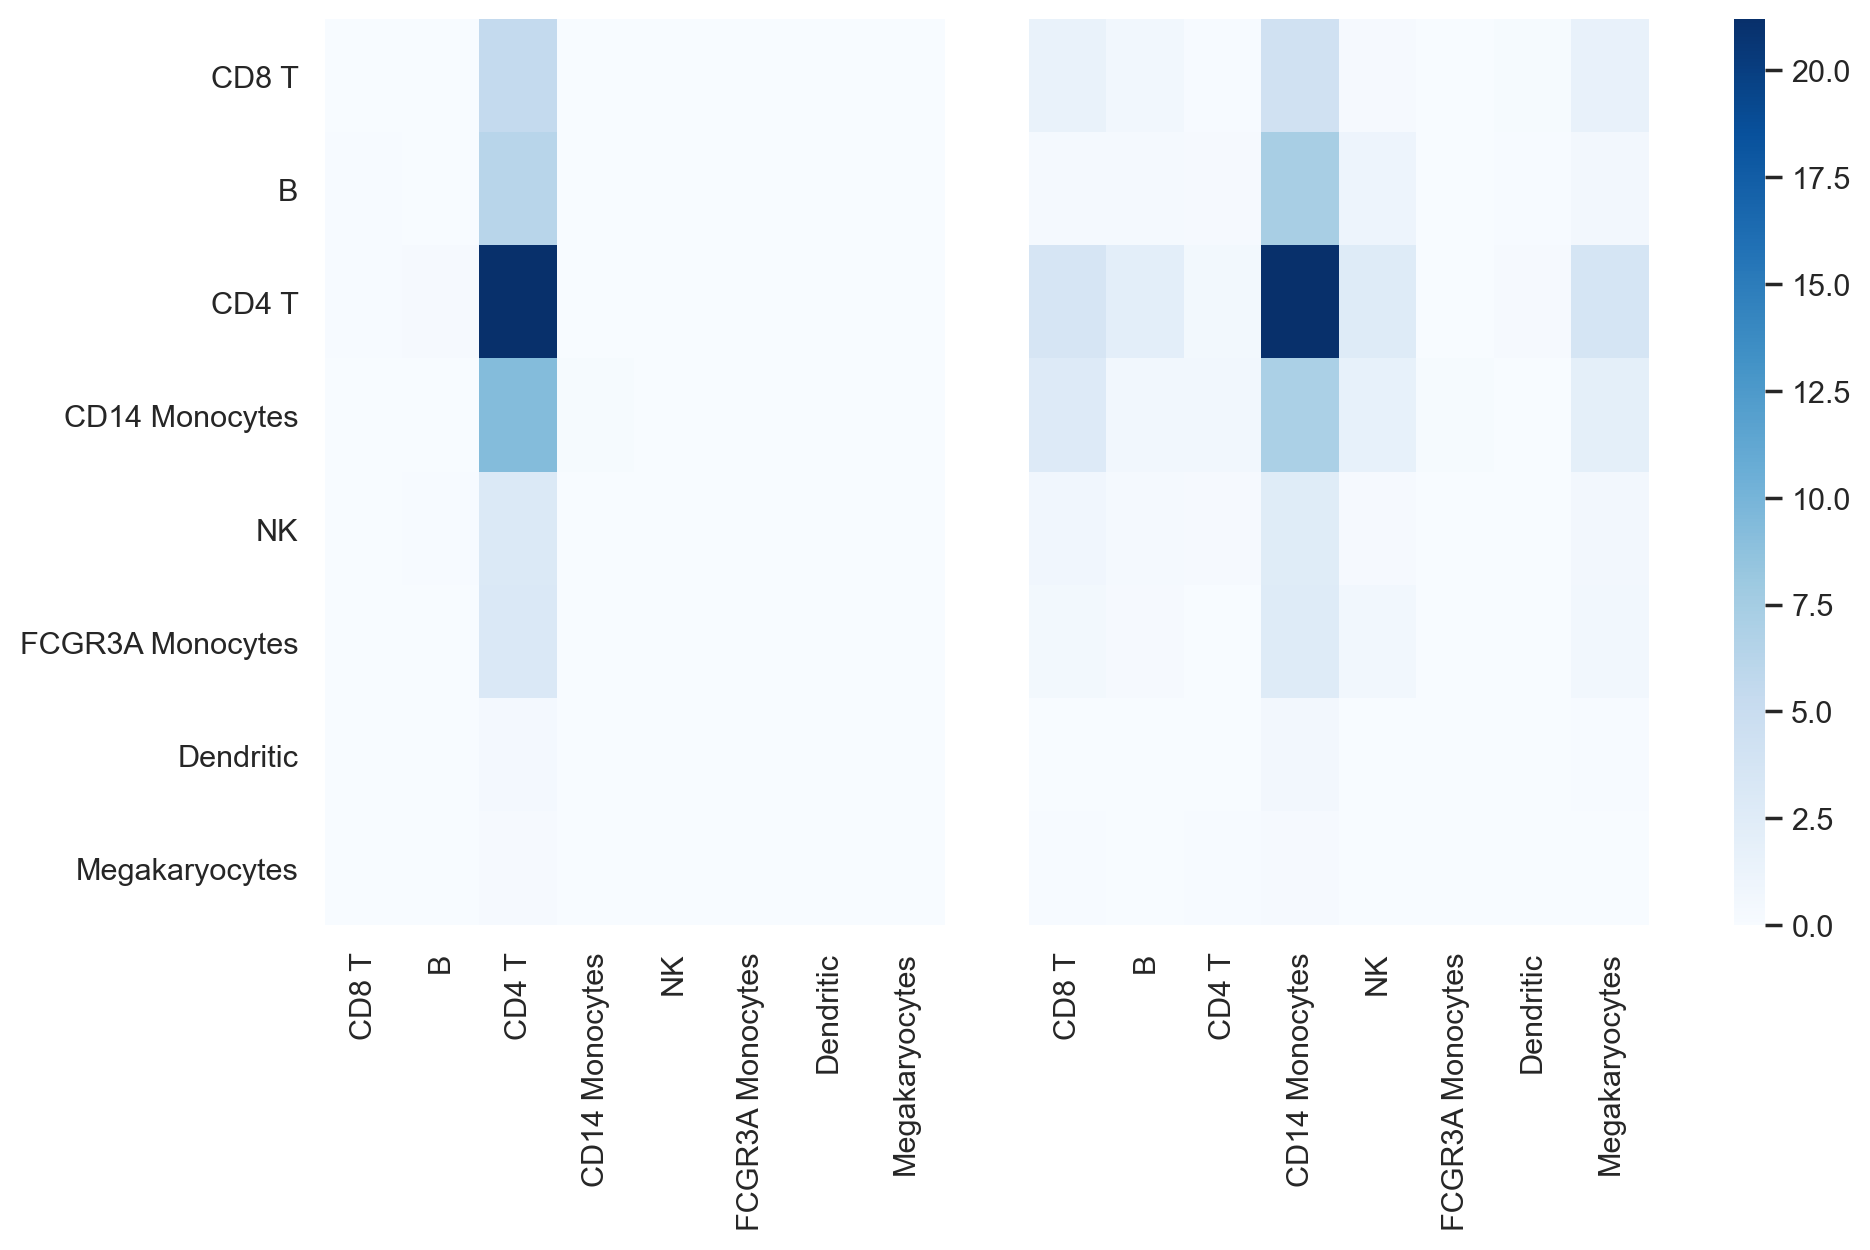

In [43]:
Heatmap(df_test['cell_type'], [y_knn_umap, arrayumap], unique_classes)

/Users/radish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


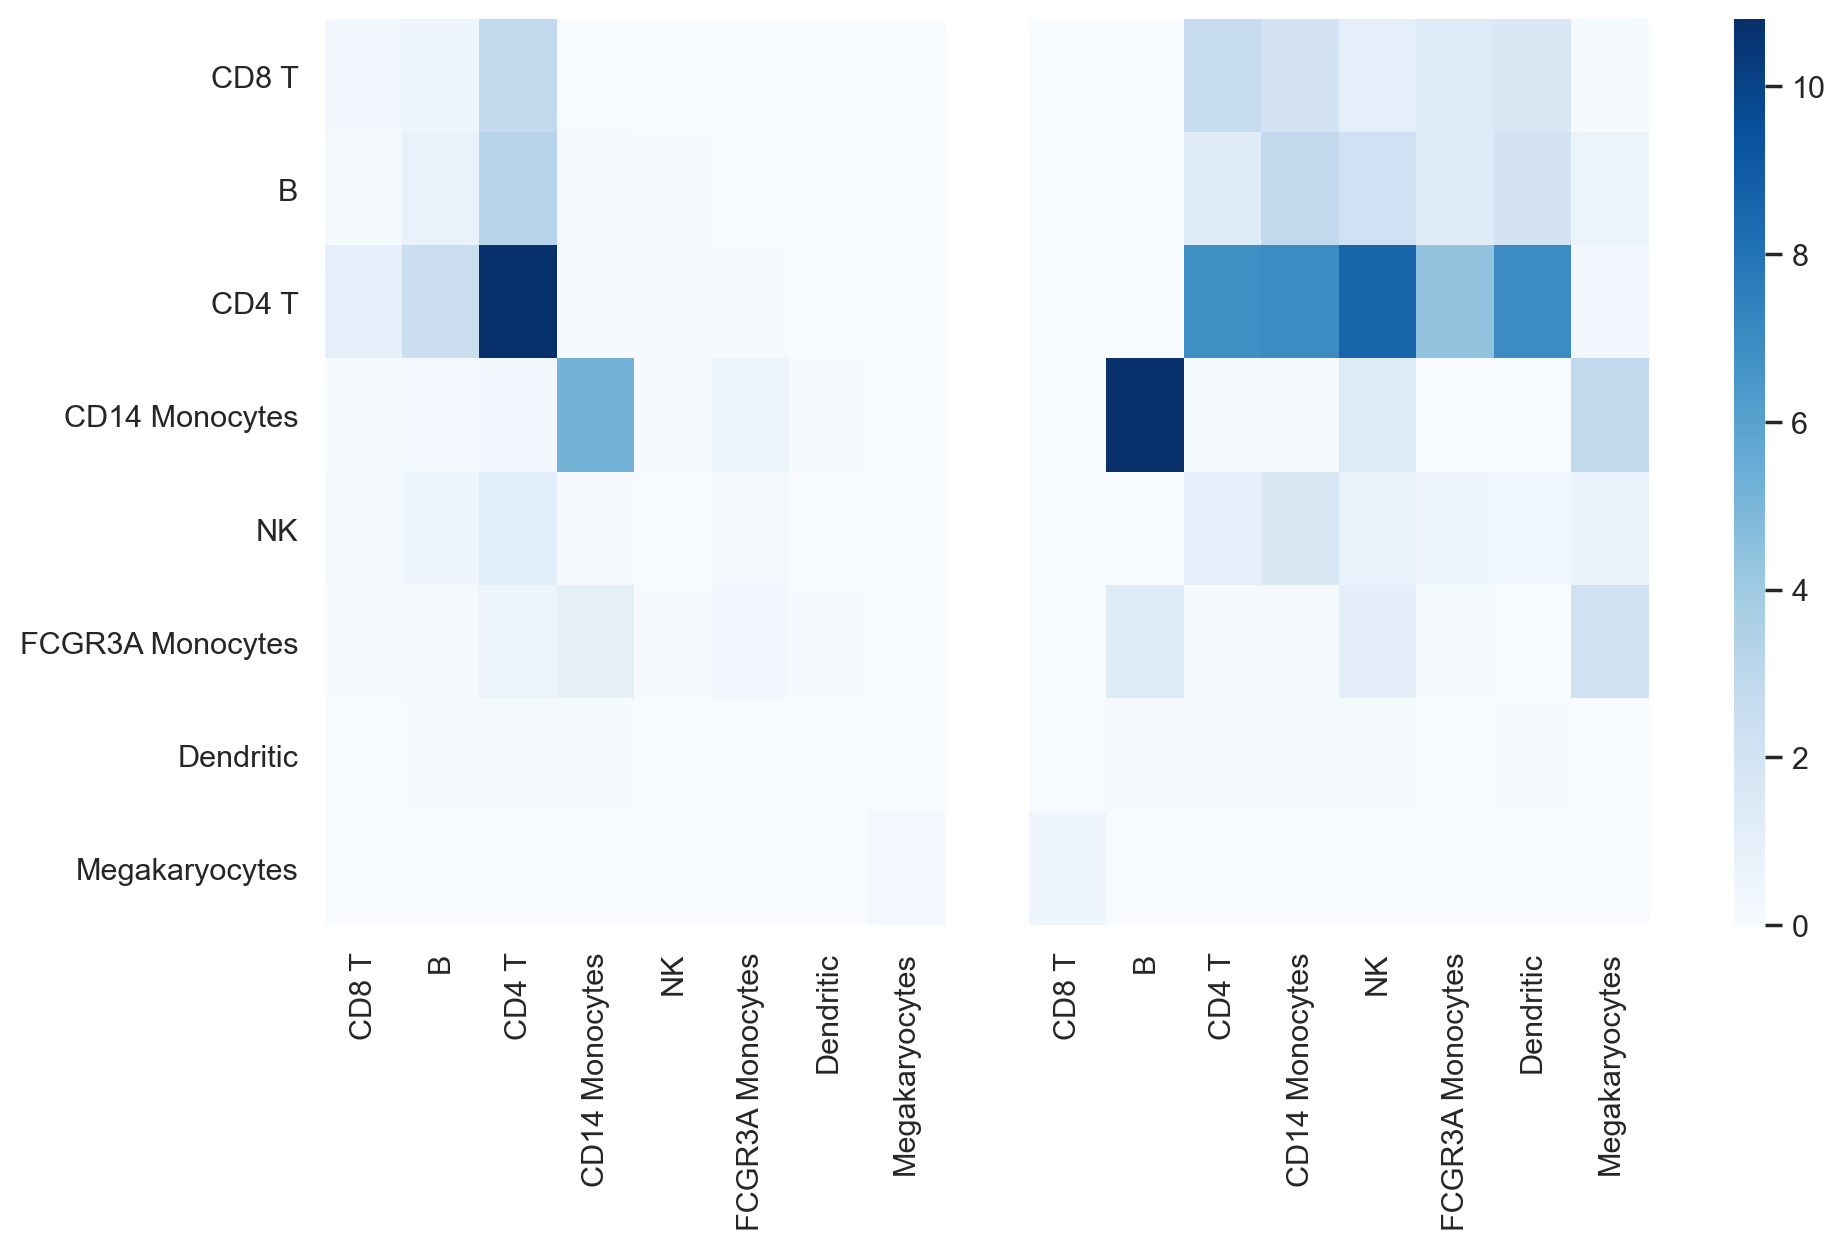

In [44]:
Heatmap(df_test['cell_type'], [y_knn_mde, arraymde], unique_classes)

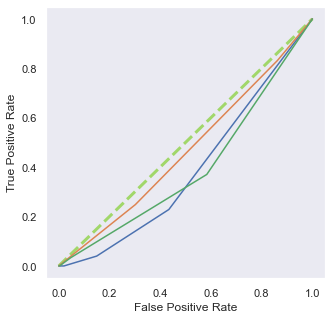

In [45]:
def binarize(y, label='CD4 T'):
    binarized = (y == label).astype(np.int)
    return binarized

y_bin = binarize(df_test['cell_type']).values.astype(np.float64)
preds = [
    neigh_tsne.predict_proba(tsne_test)[:,3],
    neigh_umap.predict_proba(umap_test)[:,3],
    neigh_mde.predict_proba(mde_test)[:,3]
]


fig, ax = plt.subplots(figsize=(5,5))
diag_x, diag_y = [0, 1], [0, 1]
ax.plot(diag_x, diag_y, linestyle='dashed', color='#a1d76a', linewidth=3)


for i, pred in enumerate(preds):
    fpr, tpr, thresholds = metrics.roc_curve(y_bin, pred, pos_label=1)

    ax.plot(tpr, fpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

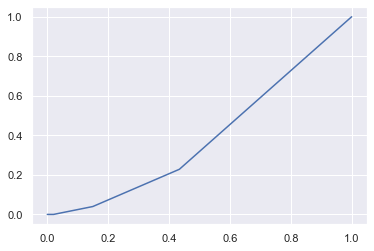

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_bin, preds[0], pos_label=1)

plt.plot(tpr, fpr)
plt.show()